# Challenge: Edit MNIST challenge images to be correctly predicted

Goal: Edit the images placed in `data/MNIST/challenge` so that the provided model predicts the correct label while keeping more than 60% of the original pixels unchanged.

Description: You are given a pre-trained `SmallCNN` model and a small set of challenge images. Your task is to minimally modify these images so the model classifies them correctly. This exercise encourages you to: 
- Explore the sample dataset in `data/MNIST/sample` to understand variation and typical inputs.
- Use explainable AI (XAI) techniques (saliency maps, Grad-CAM, Integrated Gradients, occlusion, etc.) to discover what parts of the image the model relies on.
- Propose minimal edits (pixel changes, small masks, subtle color shifts) that change model prediction while preserving at least 60% of the original pixels.

Deliverables: For each edited image, save the modified image to `data/MNIST/challenge/edited/` alongside a short report (less than 2 pages) describing the XAI insights you used and the percentage of pixels preserved. For ease of use, you have the images already in that folder and you can directly work on them. You are allowed to use any external program you want to modify the image (i.e., paint, photoshop, figma, ...).

The practice can be done by more than 1 person. Final grade would depend on the number of images correctly edited (n_images_correct) with their corresponding report and number of persons working together (n_persons) following the next formula:
$$grade = 2,5 \times n\_images\_correct - 2,5 * (n\_persons - 1)$$


In [1]:
# Imports and device
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cpu


In [2]:
# SmallCNN definition (must match the trained model architecture)
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(12*7*7, 12)
        self.fc2 = nn.Linear(12, num_classes)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))  # 14x14
        x = self.pool(x)                      # 7x7
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.nn.functional.relu(self.fc1(x)))
        return self.fc2(x)

# convenience transform
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

In [3]:
models_dir = Path('../models')
model_name = models_dir / 'small_cnn.pth'
model = torch.load(model_name, weights_only=False, map_location=device)
model.to(device) 
model.eval()

SmallCNN(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=588, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=10, bias=True)
)

0_label5.png: Pred: 1, Label: 5
1_label3.png: Pred: 1, Label: 3
2_label3.png: Pred: 1, Label: 3
3_label7.png: Pred: 3, Label: 7
4_label2.png: Pred: 6, Label: 2


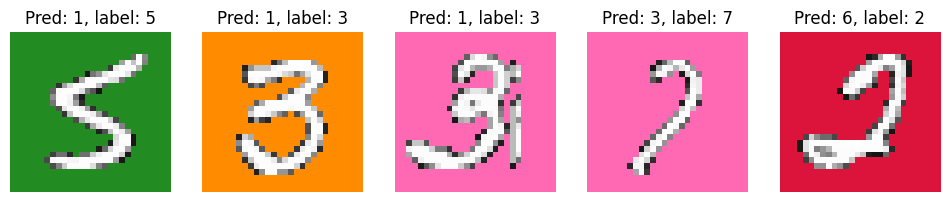

In [4]:
# Load the images in data/MNIST/challenge/ and plot them. Label of the image is the last character of the filename.
challenge_dir = Path('../data/MNIST/challenge')
image_files = list(challenge_dir.glob('*.png'))
fig, axes = plt.subplots(1, len(image_files), figsize=(12,4))
for ax, img_file in zip(axes, image_files):
    img = to_tensor(Image.open(img_file)).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1).item()
    ax.imshow(to_pil(img.squeeze().cpu()))
    ax.set_title(f'Pred: {pred}, label: {img_file.stem[-1]}')
    ax.axis('off')
    print(f'{img_file.name}: Pred: {pred}, Label: {img_file.stem[-1]}')
plt.show()

# labels = [5, 3, 3, 7, 2]

---
### Any code you want to add, put it below this markdown cell

In [5]:
# Funciones para aplicar y visualizar el método RISE
def overlay(img_pil: Image.Image, heat_hw: np.ndarray, alpha=0.55):
    """
    Función para superponer un heatmap sobre una imagen en formato PIL.

    Args:
        img_pil: imagen en formato PIL.
        heat_hw: heatmap en formato numpy array (H,W) con valores en [0,1].
        alpha: factor de transparencia del heatmap sobre la imagen base.
    """
    # Convertir imagen PIL a RGB y obtener dimensiones
    img_rgb = img_pil.convert("RGB")
    H, W = img_rgb.size[1], img_rgb.size[0]
    # Redimensionar heatmap si es necesario
    if heat_hw.shape != (H, W):
        heat_hw_img = Image.fromarray((np.clip(heat_hw,0,1)*255).astype(np.uint8)).resize((W,H), Image.BILINEAR)
        heat_hw = np.asarray(heat_hw_img)/255.0
    # Crear heatmap coloreado y superponer
    cmap = plt.get_cmap("jet")(heat_hw)[..., :3]
    base = np.asarray(img_rgb, dtype=np.float32)/255.0
    out = np.clip(alpha*cmap + (1-alpha)*base, 0, 1)
    return (out*255).astype(np.uint8)

@torch.no_grad()
def rise_saliency(model, x, target_class, N=2000, s=7, p=0.5, batch_size=128):
    """
    Implementación del método RISE para obtener saliency maps.

    Args:
        model: modelo de clasificación (en este caso, será SmallCNN).
        x: imagen de entrada (1,C,H,W).
        target_class: clase objetivo para la cual se genera el saliency map.
        N: número de máscaras aleatorias a generar.
        s: tamaño de las máscaras (número de celdas en cada dimensión).
        p: probabilidad de que una celda esté activa (1) en la máscara.
        batch_size: tamaño del batch para procesar las máscaras.
    """
    model.eval()
    # Extraer dimensiones
    _, C, H, W = x.shape
    # Número de celdas en cada dimensión
    h = int(np.ceil(H / s)); w = int(np.ceil(W / s))
    # Inicializar saliency map
    sal = torch.zeros(1, 1, H, W, device=x.device)

    for start in range(0, N, batch_size):
        # Tamaño del batch
        b = min(batch_size, N - start)
        # Crear máscaras aleatorias (distribución Bernoulli)
        masks = torch.bernoulli(torch.full((b, 1, h, w), p, device=x.device))
        # Upsampling con interpolación bilineal
        masks = F.interpolate(masks, size=(H, W), mode='bilinear', align_corners=False)
        # Extender máscaras a C canales y aplicar al batch de imágenes
        x_rep = x.repeat(b, 1, 1, 1) * masks.repeat(1, C, 1, 1)
        # Obtener puntuaciones del modelo para la clase objetivo
        scores = model(x_rep)[:, target_class]        # (b,)
        # Acumular contribuciones ponderadas en el saliency map
        sal += torch.einsum('b,bchw->chw', scores, masks).unsqueeze(0)

    # Normalizar el saliency map
    sal = sal / (N * p)
    # Normalizar a [0,1]
    if sal.max() > 0:
        sal = (sal - sal.min()) / (sal.max() - sal.min())
    sal = sal.squeeze().cpu().numpy()  # (H,W) en CPU
    return sal

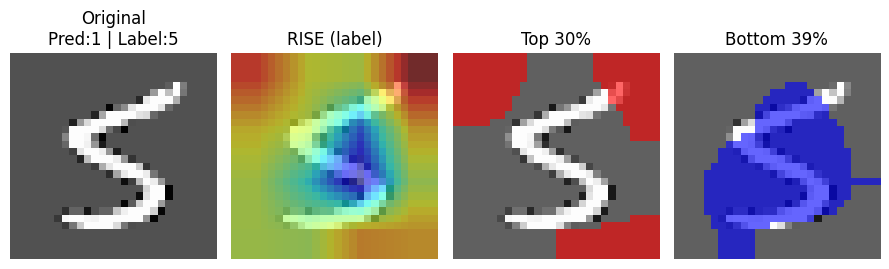

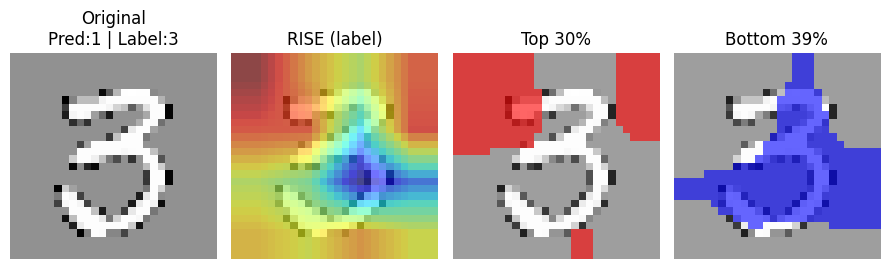

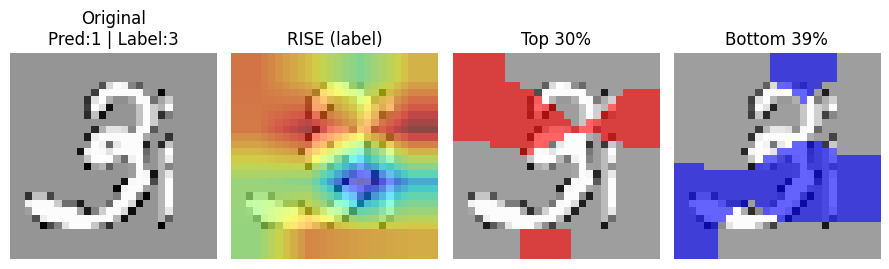

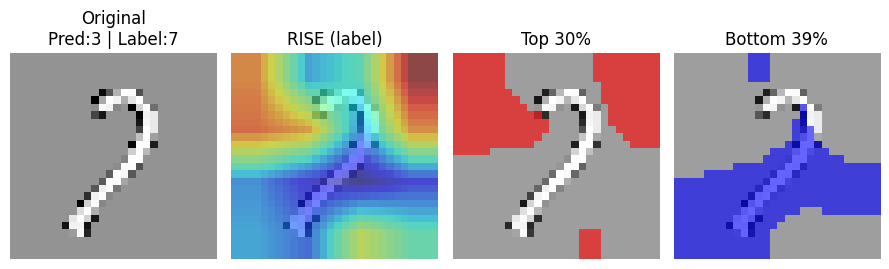

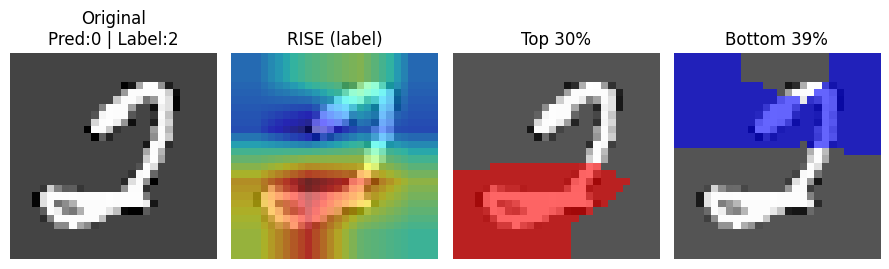

In [6]:
# RISE en todas las imágenes

# Función para extraer el número de canales de entrada
for module in model.modules():
    if isinstance(module, nn.Conv2d):
        in_ch = module.in_channels
        break

# Parámetros RISE
TARGET   = 'label' # Clase a explicar (la clase objetivo o la clase predicha)
N_MASKS  = 2000 # Número de máscaras aleatorias
CELL_S   = 7 # Tamaño de celda para las máscaras
KEEP_P   = 0.5 # Probabilidad de que una celda esté activa en la máscara
BATCH    = 128 # Tamaño del batch para procesar las máscaras
TOP_PCT  = 30 # Percentil superior para visualizar
LOW_PCT = 39 # Percentil inferior (indicará los píxeles que modificaremos)

# Guardaremos las máscaras de los píxeles menos relevantes
low40_masks = []

for image in image_files:
    img_pil = Image.open(image).convert('L')
    x = transforms.functional.to_tensor(img_pil) # (1,H,W) [0,1]
    # Ajustar canales si es necesario
    if in_ch == 3 and x.shape[0] == 1: x = x.repeat(3,1,1)
    if in_ch == 1 and x.shape[0] == 3: x = x[:1]
    # Añadir la dimensión del batch
    x = x.unsqueeze(0).to(device)

    # Obtener predicción del modelo
    logits = model(x)
    pred = int(torch.argmax(logits, dim=1).item())
    # Obtener label de la imagen
    label = int(image.stem[-1])
    # Definir la clase objetivo para explicar
    target = pred if TARGET == 'pred' else label

    # Calcular el saliency map con RISE
    heat = rise_saliency(model, x, target, N=N_MASKS, s=CELL_S, p=KEEP_P, batch_size=BATCH)

    # Definir el threshold de los píxeles más importantes
    thr = np.percentile(heat, 100 - TOP_PCT)
    mask_top40 = (heat >= thr)

    # Obtener imagen en RGB y en BW
    rgb = img_pil.convert("RGB")
    base = np.asarray(rgb, dtype=np.float32)/255.0

    # Colorear de rojo los píxeles más relevantes para la predicción de la clase objetivo
    red = base.copy()
    red[mask_top40] = [1.0, 0.0, 0.0]

    # Definir el threshold de los píxeles menos relevantes y guardar la máscara
    thr = np.percentile(heat, LOW_PCT)
    mask_low40 = (heat <= thr)
    low40_masks.append(mask_low40)

    # Colorear de azul los píxeles menos relevantes para la predicción de la clase objetivo
    blue = base.copy()
    blue[mask_low40] = [0.0, 0.0, 1.0]

    # Visualizar imagen original y saliency map
    fig, axs = plt.subplots(1, 4, figsize=(9,3))
    axs[0].imshow(img_pil, cmap='gray'); axs[0].set_title(f'Original\nPred:{pred} | Label:{label}'); axs[0].axis('off')
    axs[1].imshow(overlay(img_pil, heat)); axs[1].set_title(f'RISE ({TARGET})'); axs[1].axis('off')
    # Visualizar los píxeles más importantes (si tapo estos pixeles baja mucho la precisión)
    axs[2].imshow(np.clip(0.6*red + 0.4*base, 0, 1)); axs[2].set_title(f'Top {TOP_PCT}%'); axs[2].axis('off')
    # Visualizar los píxeles menos importantes (serán los que modificaremos)
    axs[3].imshow(np.clip(0.6*blue + 0.4*base, 0, 1)); axs[3].set_title(f'Bottom {LOW_PCT}%'); axs[3].axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
# Definir aleatoriedad
torch.manual_seed(42)

> Aunque las celdas a continuación podrían optimizarse con un bucle (el procedimiento seguido es en general el mismo para cada imagen), las hemos hecho una a una para ir viendo el proceso (logits y predicciones a medida que se iba perturbando la imagen) y la imagen resultante en cada caso.
>
> Como se explica en el informe, para las imágenes 2 y 3 las máscaras correspondientes no han sido suficientes para perturbar la imagen hasta conseguir la predicción correcta (después de 100.000 iteraciones). Por ello, para ellas hemos decidido emplear una máscara ubicada en la zona central de la imagen (donde generalmente se encuentran los dígitos en las imágenes de MNIST), reutilizando la máscara creada para la imagen 0. 

In [8]:
# Imagen 0
idx = 0
image = image_files[idx]

y_true = int(image.stem[-1]) 
print('Etiqueta verdadera:', y_true)

img_tensor = to_tensor(Image.open(image)).unsqueeze(0).to(device)  # (1,C,H,W)
img_current = img_tensor.clone()

# Máscara de los píxeles menos relevantes (píxeles a modificar)
mask_low40 = low40_masks[idx]
mask_torch = torch.tensor(mask_low40.astype(np.float32), dtype=torch.float32).unsqueeze(0).to(device)

# Parámetros de la búsqueda
learning_rate = 5
alpha = 1.5
epochs = 100000

for step in range(epochs):
    # Generar ruido dentro de la máscara
    noise = torch.randn_like(img_current) * mask_torch
    # Definir imagen candidata (perturbada)
    img_candidate = img_current + alpha * noise

    # Obtener logits para la imagen actual y la candidata
    f0 = model(img_current)
    fnoise = model(img_candidate)

    # Calcular la derivada (perturbada - actual) y actualizar la imagen actual
    df = fnoise[0, y_true] - f0[0, y_true]
    img_current += learning_rate * df * noise
    img_current = torch.clamp(img_current, 0, 1)

    # Obtener la predicción de la imagen actualizada
    with torch.no_grad():
        output = model(img_current)
        pred = output.argmax(dim=1).item()
    
    # Comprobar si la predicción es correcta
    if pred == y_true:
        print(f'\nPredicción correcta ({pred}) en el paso {step}.')
        # Guardar la imagen final
        img_final = img_current.squeeze().cpu()
        to_pil(img_final).save(f'../data/MNIST/challenge/edited/image{idx}_pred{pred}.png')
        break
    
    print(f'Step: {step}, Predicción: {pred}, Logits output: {output[:, y_true].item()}')


Etiqueta verdadera: 5
Step: 0, Predicción: 1, Logits output: 1.446992039680481
Step: 1, Predicción: 1, Logits output: 1.446992039680481
Step: 2, Predicción: 7, Logits output: 0.5353471636772156
Step: 3, Predicción: 3, Logits output: 1.2286823987960815
Step: 4, Predicción: 1, Logits output: 1.446992039680481
Step: 5, Predicción: 1, Logits output: 1.446992039680481
Step: 6, Predicción: 7, Logits output: 0.27114737033843994
Step: 7, Predicción: 7, Logits output: 0.1428452730178833
Step: 8, Predicción: 3, Logits output: 1.1376557350158691
Step: 9, Predicción: 7, Logits output: -0.3602548837661743
Step: 10, Predicción: 3, Logits output: 1.0720348358154297
Step: 11, Predicción: 1, Logits output: 1.368924617767334
Step: 12, Predicción: 3, Logits output: 1.2313002347946167
Step: 13, Predicción: 7, Logits output: 0.8701441884040833
Step: 14, Predicción: 1, Logits output: 1.446992039680481
Step: 15, Predicción: 7, Logits output: 0.23866188526153564
Step: 16, Predicción: 3, Logits output: 1.02808

In [9]:
# Imagen 1
idx = 1
image = image_files[idx]

y_true = int(image.stem[-1]) 
print('Etiqueta verdadera:', y_true)

img_tensor = to_tensor(Image.open(image)).unsqueeze(0).to(device)  # (1,C,H,W)
img_current = img_tensor.clone()

# Máscara de los píxeles menos relevantes (píxeles a modificar)
mask_low40 = low40_masks[idx]
mask_torch = torch.tensor(mask_low40.astype(np.float32), dtype=torch.float32).unsqueeze(0).to(device)

# Parámetros de la búsqueda
learning_rate = 5
alpha = 1.5
epochs = 100000

for step in range(epochs):
    # Generar ruido dentro de la máscara
    noise = torch.randn_like(img_current) * mask_torch
    # Definir imagen candidata (perturbada)
    img_candidate = img_current + alpha * noise

    # Obtener logits para la imagen actual y la candidata
    f0 = model(img_current)
    fnoise = model(img_candidate)

    # Calcular la derivada (perturbada - actual) y actualizar la imagen actual
    df = fnoise[0, y_true] - f0[0, y_true]
    img_current += learning_rate * df * noise
    img_current = torch.clamp(img_current, 0, 1)

    # Obtener la predicción de la imagen actualizada
    with torch.no_grad():
        output = model(img_current)
        pred = output.argmax(dim=1).item()
    
    # Comprobar si la predicción es correcta
    if pred == y_true:
        print(f'\nPredicción correcta ({pred}) en el paso {step}.')
        # Guardar la imagen final
        img_final = img_current.squeeze().cpu()
        to_pil(img_final).save(f'../data/MNIST/challenge/edited/image{idx}_pred{pred}.png')
        break
    
    print(f'Step: {step}, Predicción: {pred}, Logits output: {output[:, y_true].item()}')


Etiqueta verdadera: 3
Step: 0, Predicción: 1, Logits output: 1.598129153251648
Step: 1, Predicción: 1, Logits output: 1.598129153251648
Step: 2, Predicción: 1, Logits output: 1.598129153251648
Step: 3, Predicción: 1, Logits output: 1.598129153251648
Step: 4, Predicción: 1, Logits output: 1.598129153251648
Step: 5, Predicción: 1, Logits output: 1.598129153251648
Step: 6, Predicción: 1, Logits output: 1.598129153251648
Step: 7, Predicción: 1, Logits output: 1.598129153251648
Step: 8, Predicción: 1, Logits output: 1.598129153251648
Step: 9, Predicción: 1, Logits output: 1.598129153251648
Step: 10, Predicción: 1, Logits output: 1.598129153251648
Step: 11, Predicción: 1, Logits output: 1.598129153251648
Step: 12, Predicción: 1, Logits output: 1.598129153251648
Step: 13, Predicción: 1, Logits output: 1.598129153251648
Step: 14, Predicción: 1, Logits output: 1.598129153251648
Step: 15, Predicción: 1, Logits output: 1.598129153251648
Step: 16, Predicción: 1, Logits output: 1.598129153251648
St

In [10]:
# Imagen 2
idx = 2
image = image_files[idx]

y_true = int(image.stem[-1]) 
print('Etiqueta verdadera:', y_true)

img_tensor = to_tensor(Image.open(image)).unsqueeze(0).to(device)  # (1,C,H,W)
img_current = img_tensor.clone()

# Máscara de los píxeles menos relevantes (píxeles a modificar)
# Reutilizamos la máscara de la imagen 0 (tras 100.000 iteraciones sin éxito)
mask_low40 = low40_masks[0]
mask_torch = torch.tensor(mask_low40.astype(np.float32), dtype=torch.float32).unsqueeze(0).to(device)

# Parámetros de la búsqueda
learning_rate = 5
alpha = 1.5
epochs = 100000

for step in range(epochs):
    # Generar ruido dentro de la máscara
    noise = torch.randn_like(img_current) * mask_torch
    # Definir imagen candidata (perturbada)
    img_candidate = img_current + alpha * noise

    # Obtener logits para la imagen actual y la candidata
    f0 = model(img_current)
    fnoise = model(img_candidate)

    # Calcular la derivada (perturbada - actual) y actualizar la imagen actual
    df = fnoise[0, y_true] - f0[0, y_true]
    img_current += learning_rate * df * noise
    img_current = torch.clamp(img_current, 0, 1)

    # Obtener la predicción de la imagen actualizada
    with torch.no_grad():
        output = model(img_current)
        pred = output.argmax(dim=1).item()
    
    # Comprobar si la predicción es correcta
    if pred == y_true:
        print(f'\nPredicción correcta ({pred}) en el paso {step}.')
        # Guardar la imagen final
        img_final = img_current.squeeze().cpu()
        to_pil(img_final).save(f'../data/MNIST/challenge/edited/image{idx}_pred{pred}.png')
        break
    
    print(f'Step: {step}, Predicción: {pred}, Logits output: {output[:, y_true].item()}')


Etiqueta verdadera: 3
Step: 0, Predicción: 5, Logits output: 0.2858051061630249
Step: 1, Predicción: 2, Logits output: -2.90095853805542
Step: 2, Predicción: 5, Logits output: -0.8942157030105591
Step: 3, Predicción: 5, Logits output: -1.036610722541809
Step: 4, Predicción: 2, Logits output: -3.7895350456237793
Step: 5, Predicción: 5, Logits output: -0.9303323030471802
Step: 6, Predicción: 8, Logits output: -1.7435022592544556
Step: 7, Predicción: 5, Logits output: -0.12610077857971191
Step: 8, Predicción: 8, Logits output: -1.748165488243103
Step: 9, Predicción: 2, Logits output: -3.475153923034668
Step: 10, Predicción: 2, Logits output: -2.405500888824463
Step: 11, Predicción: 5, Logits output: -0.623224139213562
Step: 12, Predicción: 1, Logits output: 1.598129153251648
Step: 13, Predicción: 5, Logits output: 0.33848750591278076
Step: 14, Predicción: 5, Logits output: 0.11144447326660156
Step: 15, Predicción: 1, Logits output: 1.000246286392212
Step: 16, Predicción: 5, Logits output:

In [11]:
# Imagen 3
idx = 3
image = image_files[idx]

y_true = int(image.stem[-1]) 
print('Etiqueta verdadera:', y_true)

img_tensor = to_tensor(Image.open(image)).unsqueeze(0).to(device)  # (1,C,H,W)
img_current = img_tensor.clone()

# Máscara de los píxeles menos relevantes (píxeles a modificar)
# Reutilizamos la máscara de la imagen 0 (tras 100.000 iteraciones sin éxito)
mask_low40 = low40_masks[0]
mask_torch = torch.tensor(mask_low40.astype(np.float32), dtype=torch.float32).unsqueeze(0).to(device)

# Parámetros de la búsqueda
learning_rate = 5
alpha = 1.5
epochs = 100000

for step in range(epochs):
    # Generar ruido dentro de la máscara
    noise = torch.randn_like(img_current) * mask_torch
    # Definir imagen candidata (perturbada)
    img_candidate = img_current + alpha * noise

    # Obtener logits para la imagen actual y la candidata
    f0 = model(img_current)
    fnoise = model(img_candidate)

    # Calcular la derivada (perturbada - actual) y actualizar la imagen actual
    df = fnoise[0, y_true] - f0[0, y_true]
    img_current += learning_rate * df * noise
    img_current = torch.clamp(img_current, 0, 1)

    # Obtener la predicción de la imagen actualizada
    with torch.no_grad():
        output = model(img_current)
        pred = output.argmax(dim=1).item()
    
    # Comprobar si la predicción es correcta
    if pred == y_true:
        print(f'\nPredicción correcta ({pred}) en el paso {step}.')
        # Guardar la imagen final
        img_final = img_current.squeeze().cpu()
        to_pil(img_final).save(f'../data/MNIST/challenge/edited/image{idx}_pred{pred}.png')
        break
    
    print(f'Step: {step}, Predicción: {pred}, Logits output: {output[:, y_true].item()}')


Etiqueta verdadera: 7
Step: 0, Predicción: 1, Logits output: 0.5896317958831787
Step: 1, Predicción: 5, Logits output: -0.26891428232192993
Step: 2, Predicción: 5, Logits output: -1.6334798336029053
Step: 3, Predicción: 6, Logits output: -1.9922480583190918
Step: 4, Predicción: 2, Logits output: -4.068325042724609
Step: 5, Predicción: 5, Logits output: -1.814955234527588
Step: 6, Predicción: 1, Logits output: 0.5896317958831787
Step: 7, Predicción: 1, Logits output: 0.5896317958831787
Step: 8, Predicción: 2, Logits output: -4.971855163574219
Step: 9, Predicción: 6, Logits output: -3.1215782165527344
Step: 10, Predicción: 1, Logits output: 0.5896317958831787
Step: 11, Predicción: 5, Logits output: -1.2570194005966187
Step: 12, Predicción: 1, Logits output: 0.06369924545288086
Step: 13, Predicción: 1, Logits output: -0.18151593208312988
Step: 14, Predicción: 5, Logits output: -2.30696439743042
Step: 15, Predicción: 5, Logits output: -1.912757158279419
Step: 16, Predicción: 8, Logits outp

In [12]:
# Imagen 4
idx = 4
image = image_files[idx]

y_true = int(image.stem[-1]) 
print('Etiqueta verdadera:', y_true)

img_tensor = to_tensor(Image.open(image)).unsqueeze(0).to(device)  # (1,C,H,W)
img_current = img_tensor.clone()

# Máscara de los píxeles menos relevantes (píxeles a modificar)
mask_low40 = low40_masks[idx]
mask_torch = torch.tensor(mask_low40.astype(np.float32), dtype=torch.float32).unsqueeze(0).to(device)

# Parámetros de la búsqueda
learning_rate = 5
alpha = 1.5
epochs = 100000

for step in range(epochs):
    # Generar ruido dentro de la máscara
    noise = torch.randn_like(img_current) * mask_torch
    # Definir imagen candidata (perturbada)
    img_candidate = img_current + alpha * noise

    # Obtener logits para la imagen actual y la candidata
    f0 = model(img_current)
    fnoise = model(img_candidate)

    # Calcular la derivada (perturbada - actual) y actualizar la imagen actual
    df = fnoise[0, y_true] - f0[0, y_true]
    img_current += learning_rate * df * noise
    img_current = torch.clamp(img_current, 0, 1)

    # Obtener la predicción de la imagen actualizada
    with torch.no_grad():
        output = model(img_current)
        pred = output.argmax(dim=1).item()
    
    # Comprobar si la predicción es correcta
    if pred == y_true:
        print(f'\nPredicción correcta ({pred}) en el paso {step}.')
        # Guardar la imagen final
        img_final = img_current.squeeze().cpu()
        to_pil(img_final).save(f'../data/MNIST/challenge/edited/image{idx}_pred{pred}.png')
        break
    
    print(f'Step: {step}, Predicción: {pred}, Logits output: {output[:, y_true].item()}')


Etiqueta verdadera: 2
Step: 0, Predicción: 6, Logits output: 3.693328857421875
Step: 1, Predicción: 0, Logits output: 1.6303428411483765
Step: 2, Predicción: 0, Logits output: 0.8617373704910278
Step: 3, Predicción: 6, Logits output: 1.8532475233078003
Step: 4, Predicción: 6, Logits output: -0.4119201898574829
Step: 5, Predicción: 6, Logits output: 2.8513083457946777
Step: 6, Predicción: 0, Logits output: -0.08906984329223633
Step: 7, Predicción: 6, Logits output: 0.5717810392379761
Step: 8, Predicción: 0, Logits output: 1.658898949623108
Step: 9, Predicción: 6, Logits output: 1.088262677192688
Step: 10, Predicción: 0, Logits output: 0.15347659587860107
Step: 11, Predicción: 6, Logits output: 0.9240082502365112
Step: 12, Predicción: 0, Logits output: 0.9701565504074097
Step: 13, Predicción: 0, Logits output: -0.006819486618041992
Step: 14, Predicción: 6, Logits output: 0.42435896396636963
Step: 15, Predicción: 6, Logits output: 2.026874542236328
Step: 16, Predicción: 0, Logits output: 

---
## Check if you have passed the challenge 

In [13]:
# Check percentage of editing an image
def calculate_edit_percentage(original_img, edited_img):
    original_pixels = original_img.load()
    edited_pixels = edited_img.load()
    width, height = original_img.size
    total_pixels = width * height
    changed_pixels = 0

    for x in range(width):
        for y in range(height):
            if original_pixels[x, y] != edited_pixels[x, y]:
                changed_pixels += 1

    return (changed_pixels / total_pixels) * 100

In [14]:
# Create edited directory
edited_dir = challenge_dir / 'edited'

# Load edited images, check that they are predicted correctly and calculate edit percentages
for original_img_file, edited_img_file in zip(challenge_dir.glob('*.png'), edited_dir.glob('*.png')):
    original_img = Image.open(original_img_file)
    edited_img = Image.open(edited_img_file)
    # Convert the edited image to RGB if it's not
    if edited_img.mode != 'RGB':
        edited_img = edited_img.convert('RGB')

    # Check prediction
    img_tensor = to_tensor(edited_img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        pred = output.argmax(dim=1).item()
    
    print(f'Edited {edited_img_file.name}: Pred: {pred}, Label: {original_img_file.stem[-1]}, correct: {pred == int(original_img_file.stem[-1])}')

    # Calculate edit percentage
    edit_percentage = calculate_edit_percentage(original_img, edited_img)
    print(f'Edit Percentage: {edit_percentage:.2f}%')


Edited image0_pred5.png: Pred: 5, Label: 5, correct: True
Edit Percentage: 39.29%
Edited image1_pred3.png: Pred: 3, Label: 3, correct: True
Edit Percentage: 39.41%
Edited image2_pred3.png: Pred: 3, Label: 3, correct: True
Edit Percentage: 39.29%
Edited image3_pred7.png: Pred: 7, Label: 7, correct: True
Edit Percentage: 39.29%
Edited image4_pred2.png: Pred: 2, Label: 2, correct: True
Edit Percentage: 39.03%
